# Introduction
- The goal of this section is to train a convolutional neural network on custom images (radiographss) from scratch. To achieve this, there are few operations we need to perform, which includes:
  - Connecting google colab to our google drive
  - Data Preparation: creating training and test data from the raw data
  - Building the CNN architecture
  - Training the network with and without transfer learning using pretrained models such as Vgg16, ResNet50, DenseNet121, MobileNetV1 and EfficientNet


- Dataset:https://stanfordmlgroup.github.io/competitions/mura/

In [ ]:
# Connect Google Colab to Google Drive
# from google.colab import drive
# drive.mount("/content/drive")

In [1]:
# install opencv-python
!pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# install keras-tuner

!pip install keras-tuner


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# largedataset 128 multiclass train-test split

In [3]:
# import the required libraries
import cv2
import numpy as np
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [4]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(1042)
import random
random.seed(1042)
tf.random.set_seed(1042)

# largedata 128 multiclass gridsearch (VGG16)

Found 2744 images belonging to 7 classes.
Found 1176 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.
Epoch 1/10
86/86 [==============================] - 12865s 151s/step - loss: 1.4662 - accuracy: 0.5098 - val_loss: 0.8860 - val_accuracy: 0.7126
Epoch 2/10
86/86 [==============================] - 5406s 63s/step - loss: 0.8129 - accuracy: 0.7318 - val_loss: 0.6536 - val_accuracy: 0.7874
Epoch 3/10
86/86 [==============================] - 5163s 60s/step - loss: 0.6300 - accuracy: 0.7937 - val_loss: 0.5834 - val_accuracy: 0.7934
Epoch 4/10
86/86 [==============================] - 5159s 60s/step - loss: 0.5534 - accuracy: 0.8149 - val_loss: 0.5407 - val_accuracy: 0.8333
Epoch 5/10
86/86 [==============================] - 5069s 59s/step - loss: 0.4763 - accuracy: 0.8422 - val_loss: 0.5092 - val_accuracy: 0.8393
Epoch 6/10
86/86 [==============================] - 5228s 61s/step - loss: 0.4128 - accuracy: 0.8622 - val_loss: 0.5267 - val_accuracy: 0.8112
Epoch 7/10
86/

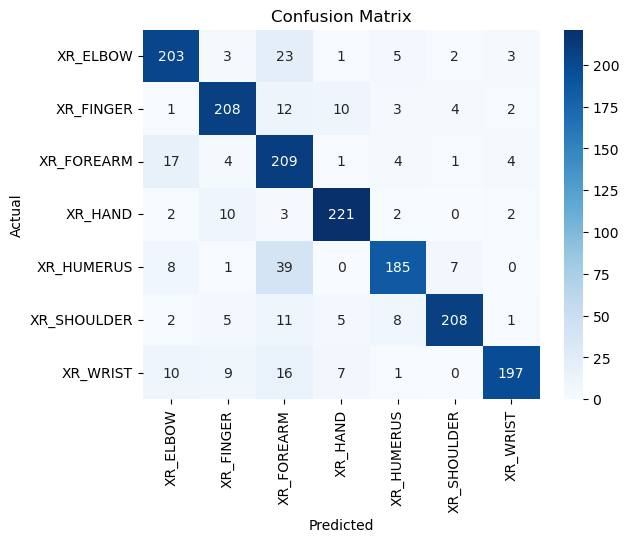

Sensitivity: [0.84583333 0.86666667 0.87083333 0.92083333 0.77083333 0.86666667
 0.82083333]
Specificity: [0.83539095 0.86666667 0.66773163 0.90204082 0.88942308 0.93693694
 0.94258373]


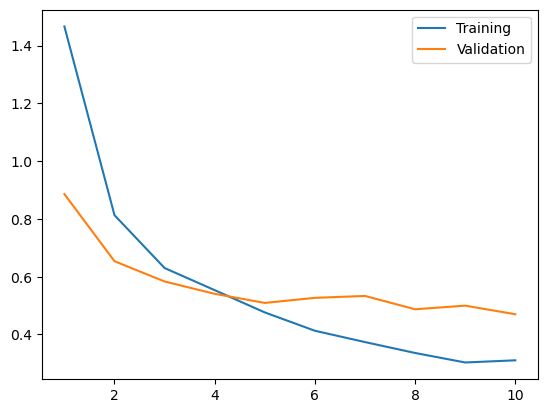

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/large_dataset/128/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/large_dataset/128/Multiclass/test"


# Data Preprocessing
image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Visualize the loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.legend(loc="best")
plt.show()

In [19]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(1042)
import random
random.seed(1042)
tf.random.set_seed(1042)

# largedata 128 multiclass 5-Fold CV vgg16

Training fold 1/5
Found 2744 images belonging to 7 classes.
Found 1176 images belonging to 7 classes.
Epoch 1/10
86/86 [==============================] - 1741s 20s/step - loss: 1.4150 - accuracy: 0.4832 - val_loss: 1.0212 - val_accuracy: 0.6658
Epoch 2/10
86/86 [==============================] - 1772s 21s/step - loss: 0.9922 - accuracy: 0.6501 - val_loss: 0.8654 - val_accuracy: 0.6896
Epoch 3/10
86/86 [==============================] - 1710s 20s/step - loss: 0.8490 - accuracy: 0.6986 - val_loss: 0.7611 - val_accuracy: 0.7338
Epoch 4/10
86/86 [==============================] - 1670s 19s/step - loss: 0.7625 - accuracy: 0.7362 - val_loss: 0.7581 - val_accuracy: 0.7270
Epoch 5/10
86/86 [==============================] - 1656s 19s/step - loss: 0.6802 - accuracy: 0.7591 - val_loss: 0.7002 - val_accuracy: 0.7560
Epoch 6/10
86/86 [==============================] - 1637s 19s/step - loss: 0.6108 - accuracy: 0.7857 - val_loss: 0.7069 - val_accuracy: 0.7457
Epoch 7/10
86/86 [======================

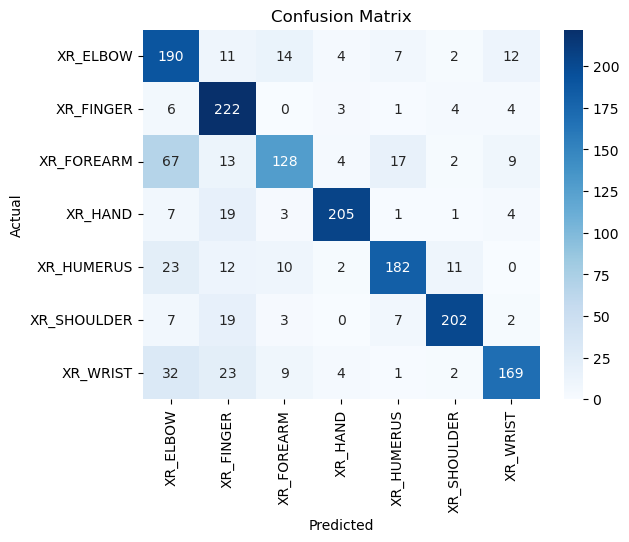

Sensitivity: [0.79166667 0.925      0.53333333 0.85416667 0.75833333 0.84166667
 0.70416667]
Specificity: [0.57228916 0.69592476 0.76646707 0.92342342 0.84259259 0.90178571
 0.845     ]


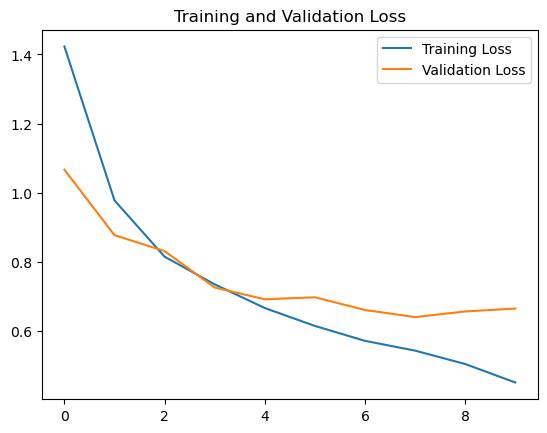

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/large_dataset/64/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/large_dataset/64/Multiclass/test"

# Data Preprocessing
image_size = (64, 64)
batch_size = 32
cv_folds = 5

# Image Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Freeze base model
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform Cross-Validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_generator.filenames)):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
    
    model = create_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Loss Visualization
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [22]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(1042)
import random
random.seed(1042)
tf.random.set_seed(1042)

# largedata 128 multiclass 10-Fold CV vgg16

Training fold 1/10
Found 2744 images belonging to 7 classes.
Found 1176 images belonging to 7 classes.
Epoch 1/10
86/86 [==============================] - 2068s 24s/step - loss: 1.4150 - accuracy: 0.4832 - val_loss: 1.0212 - val_accuracy: 0.6658
Epoch 2/10
86/86 [==============================] - 1879s 22s/step - loss: 0.9922 - accuracy: 0.6501 - val_loss: 0.8654 - val_accuracy: 0.6896
Epoch 3/10
86/86 [==============================] - 2040s 24s/step - loss: 0.8490 - accuracy: 0.6986 - val_loss: 0.7611 - val_accuracy: 0.7338
Epoch 4/10
86/86 [==============================] - 1969s 23s/step - loss: 0.7625 - accuracy: 0.7362 - val_loss: 0.7581 - val_accuracy: 0.7270
Epoch 5/10
86/86 [==============================] - 1854s 22s/step - loss: 0.6802 - accuracy: 0.7591 - val_loss: 0.7002 - val_accuracy: 0.7560
Epoch 6/10
86/86 [==============================] - 1904s 22s/step - loss: 0.6108 - accuracy: 0.7857 - val_loss: 0.7069 - val_accuracy: 0.7457
Epoch 7/10
86/86 [=====================

Epoch 4/10
86/86 [==============================] - 1377s 16s/step - loss: 0.7600 - accuracy: 0.7296 - val_loss: 0.7448 - val_accuracy: 0.7372
Epoch 5/10
86/86 [==============================] - 1384s 16s/step - loss: 0.6617 - accuracy: 0.7693 - val_loss: 0.7012 - val_accuracy: 0.7440
Epoch 6/10
86/86 [==============================] - 1317s 15s/step - loss: 0.6291 - accuracy: 0.7762 - val_loss: 0.6636 - val_accuracy: 0.7509
Epoch 7/10
86/86 [==============================] - 1308s 15s/step - loss: 0.5945 - accuracy: 0.7894 - val_loss: 0.6753 - val_accuracy: 0.7457
Epoch 8/10
86/86 [==============================] - 1266s 15s/step - loss: 0.5358 - accuracy: 0.8076 - val_loss: 0.6559 - val_accuracy: 0.7662
Epoch 9/10
86/86 [==============================] - 1259s 15s/step - loss: 0.5203 - accuracy: 0.8185 - val_loss: 0.6330 - val_accuracy: 0.7747
Epoch 10/10
86/86 [==============================] - 1271s 15s/step - loss: 0.4805 - accuracy: 0.8305 - val_loss: 0.6298 - val_accuracy: 0.771

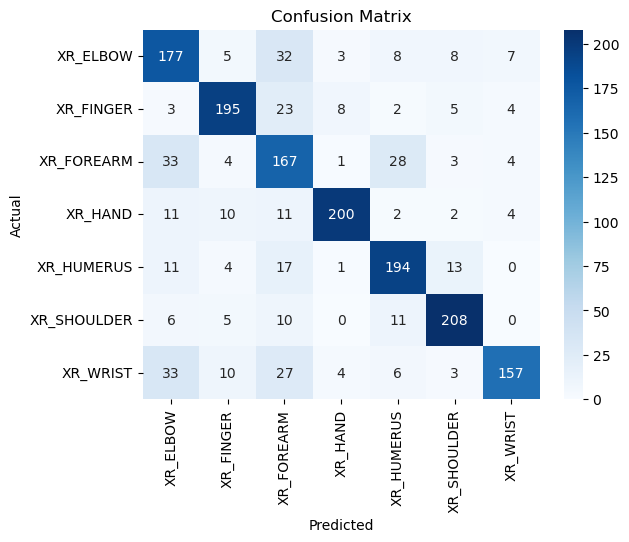

Sensitivity: [0.7375     0.8125     0.69583333 0.83333333 0.80833333 0.86666667
 0.65416667]
Specificity: [0.6459854  0.83690987 0.58188153 0.92165899 0.77290837 0.85950413
 0.89204545]


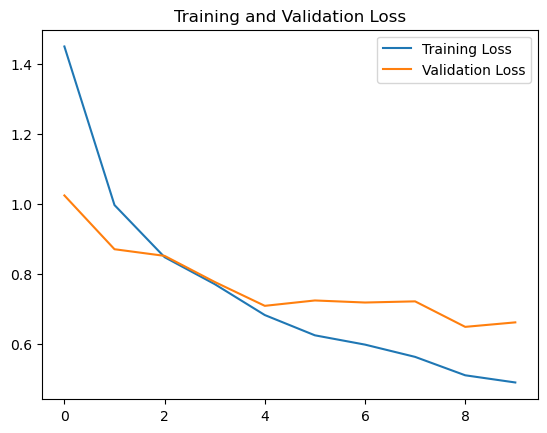

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/large_dataset/64/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/large_dataset/64/Multiclass/test"

# Data Preprocessing
image_size = (64, 64)
batch_size = 32
cv_folds = 10

# Image Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False  # Freeze base model
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform Cross-Validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_generator.filenames)):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
    
    model = create_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Loss Visualization
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()